# SMS Spam Classification

This notebook illustrates classification of SMS as SPAM or NOT SPAM. 

### Installing Dependicies

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import validation_curve

## Preprocessing and Exploring the Dataset

Importing the Dataset spam.csv

In [3]:
data = pd.read_csv('data/spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Removing unwanted columns

In [4]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})

In [5]:
data[1990:2000]

,label,text
1990,ham,HI DARLIN IVE JUST GOT BACK AND I HAD A REALLY...
1991,ham,No other Valentines huh? The proof is on your ...
1992,spam,Free tones Hope you enjoyed your new content. ...
1993,ham,Eh den sat u book e kb liao huh...
1994,ham,Have you been practising your curtsey?
1995,ham,Shall i come to get pickle
1996,ham,Lol boo I was hoping for a laugh
1997,ham,\YEH I AM DEF UP4 SOMETHING SAT
1998,ham,"Well, I have to leave for my class babe ... Yo..."
1999,ham,LMAO where's your fish memory when I need it?


In [6]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

### Some Visualisations

array([[<AxesSubplot:title={'center':'length'}>]], dtype=object)

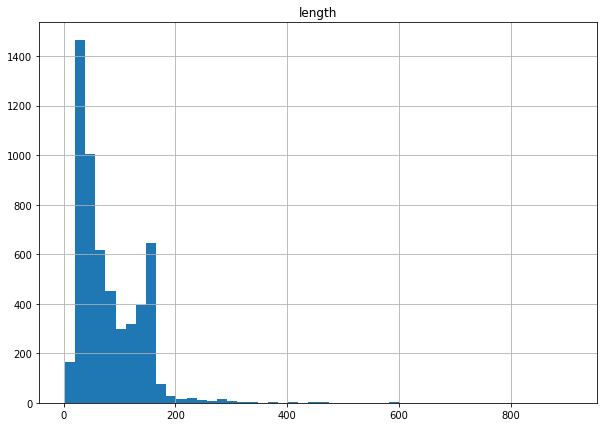

In [7]:
data['length'] = data['text'].map(lambda x: len(x))
data.hist(column='length',bins=50, figsize=(10,7))

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

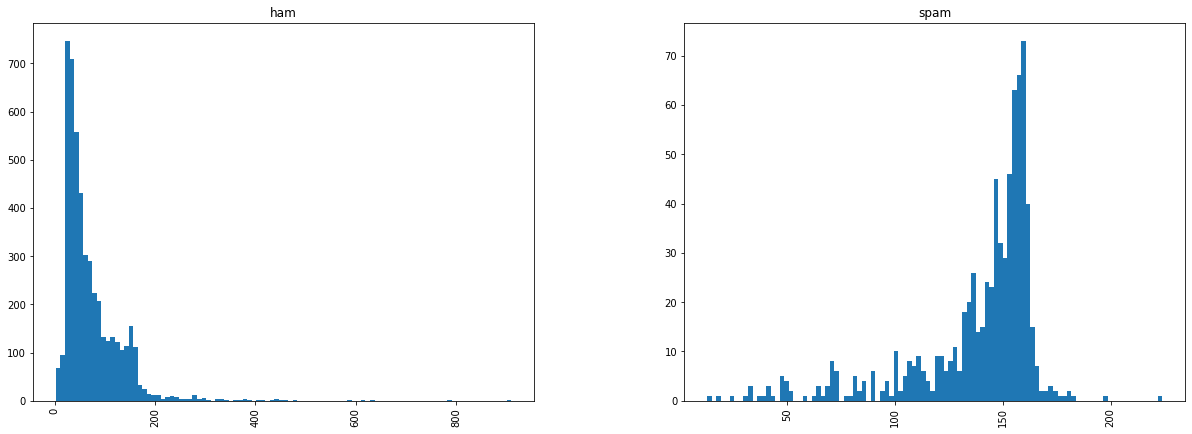

In [8]:
data.hist(column='length', by='label', bins=100, figsize=(20,7))

In [9]:
import nltk
#nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

### WordClouds- to see which words are common in SPAM and NOT SPAM mesaages

In [10]:
ham_words = ''
spam_words = ''

In [11]:
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for val in data[data['label'] == 'ham'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/sowmya/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.7/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.7/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.7/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [ ]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

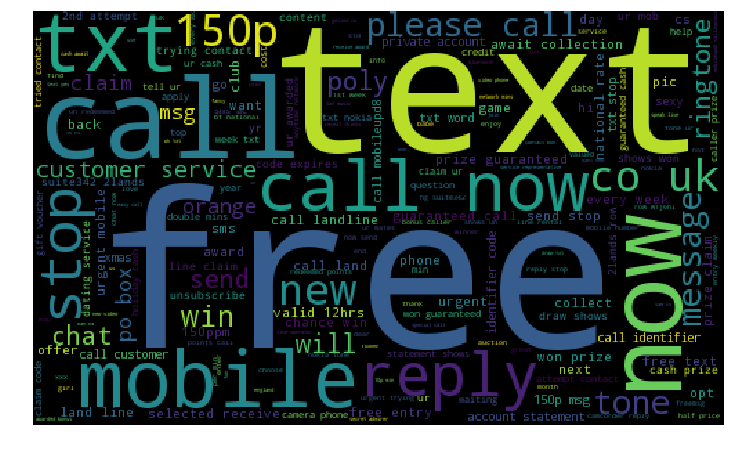

In [ ]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

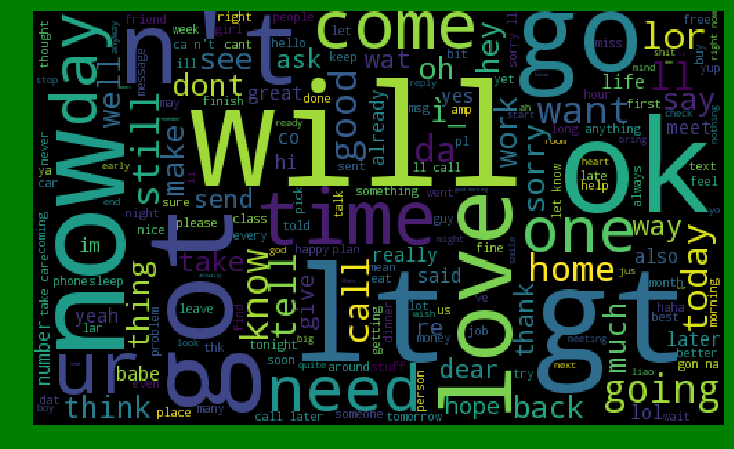

In [ ]:
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
data = data.replace(['ham','spam'],[0, 1]) 

In [ ]:
data.head(10)

,label,text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
5,1,FreeMsg Hey there darling it's been 3 week's n...,148
6,0,Even my brother is not like to speak with me. ...,77
7,0,As per your request 'Melle Melle (Oru Minnamin...,160
8,1,WINNER!! As a valued network customer you have...,158
9,1,Had your mobile 11 months or more? U R entitle...,154


### Removing Stopwords from the messages

In [ ]:
import string
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [ ]:
data['text'] = data['text'].apply(text_process)

In [ ]:
data.head()

,label,text,length
0,0,Go jurong point crazy Available bugis n great ...,111
1,0,Ok lar Joking wif u oni,29
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...,155
3,0,U dun say early hor U c already say,49
4,0,Nah dont think goes usf lives around though,61


In [ ]:
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

## Converting words to vectors

- First create a vocabulary of all words in the dataset (text messages)

- #### Vector created as follows :
 - positions with respect to highest occuring word
 - Eg : 1 at first index means first word in vocab(most frequent occuring in vocab which is 'of') occurs twice in this sentence

In [ ]:
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  11305


In [ ]:
## Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['u', '2', 'call', 'U', 'get', 'Im', 'ur', '4', 'ltgt', 'know', 'go', 'like', 'dont', 'come', 'got', 'time', 'day', 'want', 'Ill', 'lor', 'Call', 'home', 'send', 'going', 'one', 'need', 'Ok', 'good', 'love', 'back', 'n', 'still', 'text', 'im', 'later', 'see', 'da', 'ok', 'think', 'Ì', 'free', 'FREE', 'r', 'today', 'Sorry', 'week', 'phone', 'mobile', 'cant', 'tell', 'take', 'much', 'night', 'way', 'Hey', 'reply', 'work', 'make', 'give', 'new']


In [ ]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [ ]:
### Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [ ]:
## Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for ii, (_, text_) in enumerate(text.iterrows()):
    word_vectors[ii] = text_to_vector(text_[0])

In [ ]:
word_vectors.shape

(5572, 11305)

## Converting words to vectors using TFIDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5572, 9376)

## Choosing which algorithm we want to use a features : TFIDF or using custom vocabulary ?

In [ ]:
#features = word_vectors
features = vectors

### Splitting into training and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

In [ ]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(4736, 9376)
(836, 9376)
(4736,)
(836,)


## Initial Classification using XGBoost

### XGBoost using custom vocab

In [ ]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-error:0.052998
Will train until train-error hasn't improved in 50 rounds.
[10]	train-error:0.052998
[20]	train-error:0.048353
[30]	train-error:0.047086
[40]	train-error:0.048142
[50]	train-error:0.047297
[60]	train-error:0.04603
[70]	train-error:0.04772
[80]	train-error:0.044975
[90]	train-error:0.043497
[100]	train-error:0.040329
[110]	train-error:0.039907
[120]	train-error:0.039485
[130]	train-error:0.038851
[140]	train-error:0.03864
[150]	train-error:0.037584
[160]	train-error:0.036951
[170]	train-error:0.035473
[180]	train-error:0.033361
[190]	train-error:0.032728
[200]	train-error:0.031461
[210]	train-error:0.030828
[220]	train-error:0.030405
[230]	train-error:0.029772
[240]	train-error:0.029139
[250]	train-error:0.028716
[260]	train-error:0.027872
[270]	train-error:0.027872
[280]	train-error:0.026182
[290]	train-error:0.025971
[300]	train-error:0.025549
[310]	train-error:0.024916
[320]	train-error:0.024282
[330]	train-error:0.024282
[340]	train-error:0.024282
[350]	trai

### XGBoost using TFIDF

In [ ]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=400, verbose_eval=10)

[0]	train-error:0.035262
Will train until train-error hasn't improved in 400 rounds.
[10]	train-error:0.035895
[20]	train-error:0.034206
[30]	train-error:0.03125
[40]	train-error:0.029561
[50]	train-error:0.026182
[60]	train-error:0.02576
[70]	train-error:0.024704
[80]	train-error:0.024493
[90]	train-error:0.02386
[100]	train-error:0.023438
[110]	train-error:0.021748
[120]	train-error:0.021326
[130]	train-error:0.021748
[140]	train-error:0.021959
[150]	train-error:0.021748
[160]	train-error:0.021537
[170]	train-error:0.020481
[180]	train-error:0.020059
[190]	train-error:0.019426
[200]	train-error:0.019426
[210]	train-error:0.019003
[220]	train-error:0.018792
[230]	train-error:0.018581
[240]	train-error:0.01837
[250]	train-error:0.017736
[260]	train-error:0.017525
[270]	train-error:0.017314
[280]	train-error:0.017103
[290]	train-error:0.01647
[300]	train-error:0.016047
[310]	train-error:0.015836
[320]	train-error:0.015625
[330]	train-error:0.014992
[340]	train-error:0.014992
[350]	train

In [ ]:
from sklearn.metrics import accuracy_score

# Predict values for test set
d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

# Apply function round() to each element in np array
# so predictions are all either 0 or 1.
npround = np.vectorize(round)
p_test_ints = npround(p_test)

# Error rate for test set
accuracy = accuracy_score(y_test, p_test_ints)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.971291866029


Test Accuracy using TFIDF Algorithm:  0.971291866029

Test Accuracy using custom vocab:     0.972488038278

## Classifying using sklearn pre built classifiers

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [ ]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [ ]:
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [ ]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

## Predictions using TFIDF Vectorizer algorithm

In [ ]:
predictions = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
predictions

,Score
SVC,0.978469
KN,0.933014
NB,0.988038
DT,0.960526
LR,0.953349
RF,0.979665


## Predictions using custom vocabulary

In [ ]:
predictions_word_vectors = pd.DataFrame.from_items(pred_scores_word_vectors,orient='index', columns=['Score_'])
predictions_word_vectors

,Score_
SVC,0.922249
KN,0.867225
NB,0.977273
DT,0.971292
LR,0.983254
RF,0.973684


## Plot of scores TFIDF Vectorizer algorithm

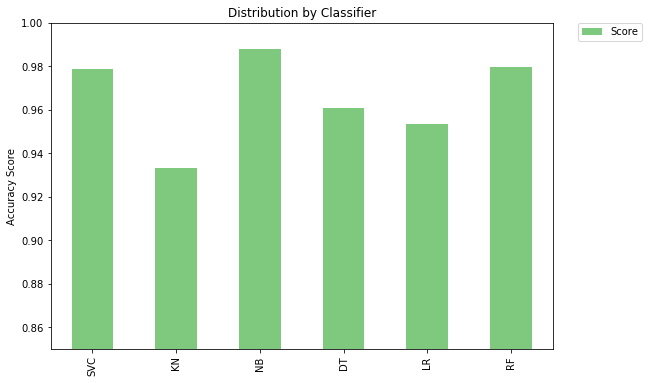

In [ ]:
predictions.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Plot of scores custom vocabulary

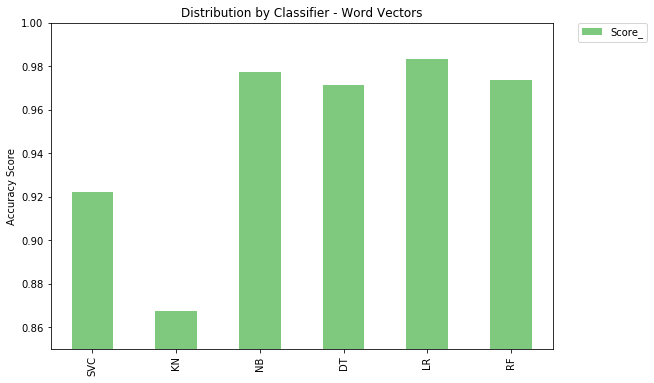

In [ ]:
predictions_word_vectors.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions_word_vectors.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier - Word Vectors')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
def find(p):
    if p == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [ ]:
text = ["Free tones Hope you enjoyed your new content"]
integers = vectorizer.transform(text)

In [ ]:
p = mnb.predict(integers)[0]
find(p)        

Message is SPAM


## Saving the Best Model

In [ ]:
from sklearn.externals import joblib
joblib.dump(mnb, 'best.pkl')
print ("Best Model (Naive Bayes) Saved")

Best Model (Naive Bayes) Saved


In [ ]:
best = joblib.load('best.pkl')

In [ ]:
best

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)

## Testing our classifiers

In [ ]:
text1 = ["Free tones Hope you enjoyed your new content"]
text2 = ["No. I meant the calculation is the same. That I'll call later"]
text3 = ["Had your contract mobile 11 Mnths? Latest Motorola Now"]
text4 = ["WINNER!! You just won a free ticket to Bahamas. Send your Details"]

integers1 = vectorizer.transform(text1)
integers2 = vectorizer.transform(text2)
integers3 = vectorizer.transform(text3)
integers4 = vectorizer.transform(text4)

In [ ]:
p1 = best.predict(integers)[0]
p2 = best.predict(integers)[0]
p3 = best.predict(integers)[0]
p4 = best.predict(integers)[0]

find(p1)
find(p2)
find(p3)
find(p4)

Message is SPAM
Message is SPAM
Message is SPAM
Message is SPAM
